In [8]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os
from shapely.ops import unary_union
from shapely.geometry import Point

In [5]:
#gdf = gpd.read_file('geology_java.gpkg')
pts = pd.read_csv('resistivity.csv')
pts = pts[pts.Region.isin(['Bali','Jawa'])]

In [18]:
loc = gpd.GeoDataFrame(
    data=pts,
    geometry=gpd.points_from_xy(pts.Lon, pts.Lat), crs=4326)
mer = gpd.sjoin_nearest(loc.to_crs(3857), gdf.to_crs(3857), how='inner')
mer = mer.to_crs(4326)

In [25]:
lookup = {}
for i,row in mer.iterrows():
    a = row.SYMBOLS
    if a in lookup:
        lookup[a].append(row.Ravg)
    else:
        lookup[a] = [row.Ravg]
        
for a in lookup:
    lookup[a] = np.nanmean(lookup[a])
lookup

{'Qva': 596.0,
 'Qp': 229.0,
 'Qbb': 332.5,
 'Tomk': 64.0,
 'Tmwl': 16.0,
 'Qvu3': 10.0,
 'Tmps': 84.0,
 'Tpg': 6.0,
 'Tpc2': 56.0,
 'Qpvb': 750.0,
 'Qa': 23.333333333333332,
 'Qjmf': 1.0,
 'Qls1': 1.0,
 'Tmpk1': 1.0,
 'Tmpm': 120.0,
 'Tmcl': 51.0,
 'Qvs2': 734.0,
 'Qac': 12.0,
 'Qy': 23.0,
 'Tmci': 500.0}

In [32]:
gdf['val'] = [lookup[a] if a in lookup else np.nan for a in gdf.SYMBOLS]

In [46]:
shore = gpd.read_file('coastline/ne_10m_coastline.shp')
#shore = shore[shore.iso_a3 == 'IDN']
shore.head(1)

,featurecla,scalerank,min_zoom,geometry
0,Coastline,0,0.0,"LINESTRING (59.91603 -67.40049, 59.67856 -67.3..."


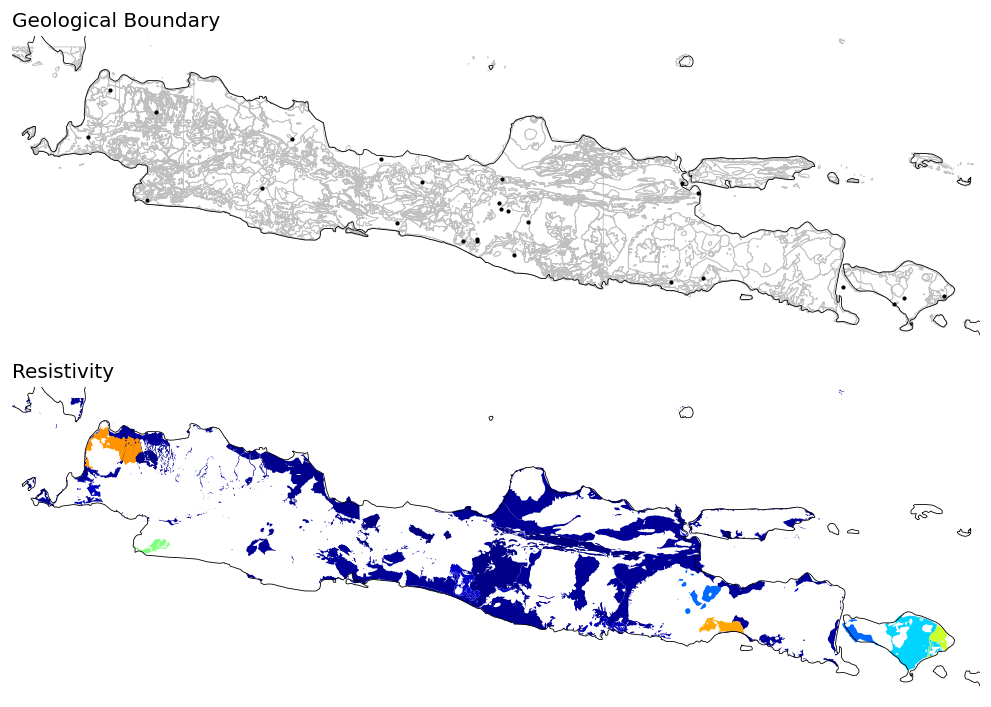

In [55]:
fig,ax = plt.subplots(2, 1, figsize=(10,6), dpi=120)
gdf.boundary.plot(color='0.75', lw=0.5, ax=ax[0])
ax[0].plot(pts.Lon, pts.Lat, '.k', ms=3)

gdf.plot(column='val', vmin=0, vmax=1000, cmap='jet', ax=ax[1])

title=['Geological Boundary', 'Resistivity']
for i in [0,1]:
    shore.plot(color='k', lw=0.5, ax=ax[i])
    ax[i].set_title(title[i], loc='left')
    ax[i].set_xlim(105, 116)
    ax[i].set_ylim(-9.0, -5.5)
    ax[i].set_axis_off()

plt.tight_layout()
plt.show()

In [8]:
path = 'C:/Users/rp1y21/Downloads/'

folders = {
    '11':'Banten',
    '12':'Jawa Barat',
    '13':'jawa Tengah',
    '15':'Jawa Timur',
    '17':'Bali'
}

tgt = '16. Geology DKI Jakarta/16. Geology DKI Jakarta/Geology DKI Jakarta.shp'
g1 = gpd.read_file(path + tgt)

for f in folders:
    tgt = f'{f}. Geology {folders[f]}/{f}. Geology {folders[f]}/Geology {folders[f]}.shp'
    g2 = gpd.read_file(path + tgt)
    pts = g2.geometry.representative_point()

    for i in range(len(pts)):
        a = g1.geometry.contains(pts[i])
        b = sum(a)
        if b < 1:
            g1 = pd.concat([g1, g2[i:i+1]], ignore_index=True)
        else:
            c = np.where(a)[0][0]
            a1 = g1.iloc[c:c+1].to_crs(3857).area.values[0]
            a2 = g2.iloc[i:i+1].to_crs(3857).area.values[0]
            if a2 > a1:
                g1.drop([c])
                g1 = pd.concat([g1, g2[i:i+1]], ignore_index=True)
    
g1.plot()
